In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Reference: 

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://www.kaggle.com/dhruv1234/huggingface-tfbertmodel

In [2]:
!pip install transformers

In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [4]:
from transformers import BertTokenizer
PRE_TRAINED_MODEL_NAME = 'bert-large-uncased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [5]:
all_tweets = np.concatenate([train.text.values, test.text.values])

token_lens = []
for txt in all_tweets:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [6]:
MAX_LEN = max(token_lens)
MAX_LEN

84

In [7]:
import numpy as np
import tensorflow as tf 

In [8]:
def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for i in range(len(data.text)):
          encoded = tokenizer.encode_plus(       
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_length,
            padding='max_length', 
            truncation=True,
            return_attention_mask=True      
          )

          input_ids.append(encoded['input_ids'])
          attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [9]:
CUSTOM_MAX_LEN = 55

In [10]:
train_input_ids, train_attention_masks = bert_encode(train, CUSTOM_MAX_LEN)
test_input_ids, test_attention_masks = bert_encode(test, CUSTOM_MAX_LEN)
print(len(train_input_ids))
print(len(train_attention_masks))
print(len(test_input_ids))
print(len(test_attention_masks))

7613
7613
3263
3263


In [11]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

def create_model(bert_model, max_len, n_units, dropout, lr):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(n_units, activation='relu')(output)
    output = tf.keras.layers.Dropout(dropout)(output)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
from transformers import TFBertModel
bert_model_tensorflow = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

2022-01-22 03:36:06.044883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 03:36:06.045872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 03:36:06.046514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 03:36:06.047419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
CUSTOM_MAX_LEN = 55
N_UNITS = 32
DROPOUT = 0.15
LR = 6e-6
model = create_model(bert_model_tensorflow, CUSTOM_MAX_LEN, N_UNITS, DROPOUT, LR)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]          

In [14]:
history = model.fit([train_input_ids, train_attention_masks],
                    train.target,
                    validation_split=0.2, 
                    epochs=1,
                    batch_size=10)

2022-01-22 03:36:22.593309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


609/609 [==============================] - 186s 277ms/step - loss: 0.4789 - accuracy: 0.7808 - val_loss: 0.4174 - val_accuracy: 0.8306


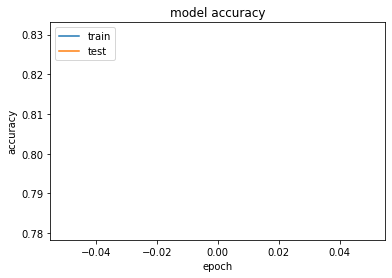

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

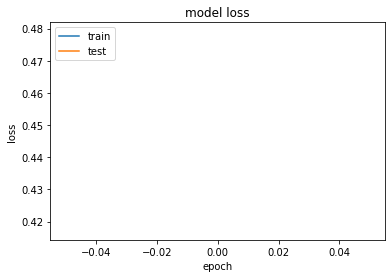

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
result = model.predict([test_input_ids, test_attention_masks])
result

array([[0.41661268],
       [0.9462394 ],
       [0.9072921 ],
       ...,
       [0.94381726],
       [0.8603103 ],
       [0.8607044 ]], dtype=float32)

In [18]:
preds = np.round(result).astype(int)
preds

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [19]:
submission['target'] = preds
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [20]:
submission.to_csv('submission.csv', index=False)